# Clustering and Classification of Glitches

Many sources can produce noise that obscures or attenuates true gravitational wave (GW) signals. When interferometers detect these noises with different intensities than usual, points in the frequency-time window (called triggers) appear. A set of points in a short observation time window are glitches, and our goal is to classify them. The clustering process involves taking a set of triggers and representing it as just one glitch and this is important because each source produces its own type of glitche, so classifying them makes it easier to identify their origin.

This work will use some functions and ideas from **Francesco Di Renzo** tutorial, available at: **https://drive.google.com/drive/u/0/folders/1s_HT3qvLBzIRA8VYxifLB4Pk-D9xdL20**. To access the Cascina server (Virgo) you need to be logged into Virgo account. The necessary steps is brief comment in this characterization tutorial: **https://drive.google.com/drive/u/0/folders/1s_HT3qvLBzIRA8VYxifLB4Pk-D9xdL20** and are important because some functions only work inside this server.

In [1]:
# Importação
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.filterwarnings("ignore", message="Pandas requires version")

import os
import ast
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime, timedelta
from gwpy.time import to_gps
from gwpy.table import EventTable
from astropy.table import unique as at_unique
from astropy.units import  Unit, dimensionless_unscaled
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag
from virgotools import getChannel

The triggers are cataloged within several files. The following function **find_trigger_files()** is a routine to search for trigger files (from Omicron) within a detector's data directory. The parameters are as follow:

* **ch**: data channel, used to build the folders path.
* **start** and **end**: are beginning and end of time  in GPStime
* **trigpath**: is the path where the triggers files are (by default: /data/*/omicron/)
* **ext**: is just the extension of files that we wanted (by default: .root)

In [2]:
def find_trigger_files(ch, start, end, trigpath="/data/*/omicron/", ext="root"):
    allfiles = glob(os.path.join(trigpath, "{}/{}_OMICRON".format(*ch.split(":")), "**", f"*.{ext}"), recursive=True)
    if not allfiles:
        print(f"Nenhum arquivo encontrado no caminho {trigpath}")
        return []
    allstart, alldur = np.array([f.rstrip(f".{ext}").split("-")[-2:] for f in allfiles]).astype(int).T
    try:
        rightfiles = np.asarray(allfiles)[(allstart + alldur > start) & (end > allstart)]
    except TypeError:
        print(f"Nenhum arquivo relevante encontrado entre {start} e {end}")
        return []
    return rightfiles

It is worth noting that we have a lot of channels that it is possible to access, and they contain information about a lot of features of interferometers, like temperature, operating time or GWs signals, for exemple. Now lets see the files that are in the gravitational channel of Virgo interferometer **V1:Hrec_hoft_16384Hz**, in the beggining of O4a run:

In [98]:
start = to_gps("2024-05-24 16:00").gpsSeconds
end = to_gps("2024-05-29 12:00").gpsSeconds

In [99]:
trigfiles = find_trigger_files("V1:Hrec_hoft_16384Hz", start, end)

In [100]:
trigfiles

array(['/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14006/V1-Hrec_hoft_16384Hz_OMICRON-1400600086-100212.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14007/V1-Hrec_hoft_16384Hz_OMICRON-1400700298-99904.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14008/V1-Hrec_hoft_16384Hz_OMICRON-1400800202-99904.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14009/V1-Hrec_hoft_16384Hz_OMICRON-1400900106-99895.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14010/V1-Hrec_hoft_16384Hz_OMICRON-1401000001-100189.root'],
      dtype='<U109')

We have a lot of data separated into these five files. Lets turn the **first one** into a table:

In [103]:
from gwpy.table import EventTable

gltab = EventTable.read(trigfiles[0].tolist(), treename='triggers;1', nproc=3)
gltab.sort("time")
print(f"{len(gltab)} triggers have been found")

767621 triggers have been found


In [104]:
gltab

time,frequency,q,snr,tstart,tend,fstart,fend,amplitude,phase,tstart_us
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
1400600092.944336,1496.3695261555615,38.073078774317565,5.333692030782796,1400600092.943359,1400600092.945313,1476.2350592320633,1516.7786083957453,1.8035238480425022e-22,-1.3227672768757988,943359
1400600092.944336,1537.4660514489544,38.073078774317565,5.3561994577565635,1400600092.943359,1400600092.945313,1516.7786083957453,1558.4356518965983,1.873364750617949e-22,1.4188686327571292,943359
1400600094.9375,40.61665305221255,72.47796636776955,5.112796582070696,1400600094.875,1400600095.0,40.32883760932051,40.90652255205435,8.179356344720786e-23,-0.9878411641768023,875000
1400600095.0625,40.61665305221255,72.47796636776955,5.09803107819023,1400600095.0,1400600095.125,40.32883760932051,40.90652255205435,8.155734767779663e-23,-0.9844473857759105,0
1400600103.131103,1484.119924161413,10.506111217615068,5.74462413739907,1400600103.130859,1400600103.131348,1415.0117901675303,1556.6032485369612,1.9389315448064682e-22,-2.5303353681221816,130859
1400600103.131103,1349.1216806111363,10.506111217615068,5.408535506550351,1400600103.130859,1400600103.131348,1286.2997479897485,1415.0117901675303,1.6829217711551428e-22,1.9279785387968262,130859
...,...,...,...,...,...,...,...,...,...,...
1400700284.041504,1027.5492200215158,19.999999999999996,5.15394753818052,1400700284.041015,1400700284.041993,1001.6420682614987,1054.1264519764286,1.2239804068286379e-22,0.17339651105612294,41016
1400700287.030273,322.68814629298936,10.506111217615068,5.134910247444668,1400700287.029297,1400700287.03125,307.6621532521276,338.4479977707028,5.512611023307733e-23,0.34981780161346115,29297


Each line in this output represents one trigger and its  characteristics, such as frequency, **q** value, **snr** value or even its small punctual time interval **fstart-fend** (perhaps used for error calculations). The q value measures the ratio between center frequency and bandwidth and indicates whether the signal is short or long in time, while the SNR measures signal strength relative to noise.

The following function **clusterize_triggers()** is to identify sets of triggers and turn into a unique glitch, where the representative point is the one with the largest signal-to-noise ratio (SNR). This function will receive the previous **table** that we choose and the **window** in seconds. We calculate the time between the end of one trigger and the start of the next (from **delta_t**). If this interval is less than or equal to the window value, the triggers are considered to be from the same cluster.

In [45]:
#Processo de clusterização
def clusterize_triggers(table, window=0.1):
    if len(table) == 0:
        return EventTable(rows=[])  # retorna tabela vazia se não houver triggers

    table = table.copy()
    table.sort('tstart')

    cluster_ids = np.zeros(len(table), dtype=int)
    cluster_index = 0
    for i in range(1, len(table)):
        delta_t = table[i]['tstart'] - table[i-1]['tend']
        if delta_t <= window:
            cluster_ids[i] = cluster_index
        else:
            cluster_index += 1
            cluster_ids[i] = cluster_index

    table['cluster'] = cluster_ids
    summary_rows = []
    for cl in np.unique(cluster_ids):
        cluster_rows = table[table['cluster'] == cl]
        if len(cluster_rows) == 0:
            continue
        max_idx = np.argmax(cluster_rows['snr'])
        max_row = cluster_rows[max_idx]

        summary_rows.append({
            'cluster': cl,
            'tstart': np.min(cluster_rows['tstart']),
            'tend': np.max(cluster_rows['tend']),
            'fmin': np.min(cluster_rows['fstart']),
            'fmax': np.max(cluster_rows['fend']),
            'time': max_row['time'],
            'frequency': max_row['frequency'],
            'q': max_row['q'],
            'snr': max_row['snr'],
            'phase': max_row['phase']
        })
    return EventTable(rows=summary_rows)

Furthermore, the function bellow calculate the operation time of the interferometer, from data quality channel **chDQ**. This result will be used to find the rate of glitches per time.

In [51]:
# Função para calcular tempo ativo
def dq_active_seconds(chDQ, state_val, start_dt, end_dt, label="Low Noise"):
    """Retorna (total_active_seconds, DQflag) no intervalo [start_dt, end_dt]."""
    start = to_gps(start_dt).gpsSeconds if hasattr(to_gps(start_dt), "gpsSeconds") else to_gps(start_dt)
    end   = to_gps(end_dt).gpsSeconds   if hasattr(to_gps(end_dt), "gpsSeconds")   else to_gps(end_dt)

    DQTS = read2TS("trend", chDQ, start, end)
    sTS = DQTS >= state_val
    DQ = sTS.to_dqflag(label=label)

    total_active = float(sum(seg[1] - seg[0] for seg in DQ.active))  # segundos
    return total_active, DQ

Now lets start the key part of this code, where we will choose the SNR intervals we wanted, take the operation time of the detector and clusteryze the triggers. All this process occur inside a time interval window that we choose.

In [91]:
#Janela de operação
run_start_day = datetime(2024, 6, 1, 23, 59, 59)
run_end_day   = datetime(2024, 6, 10, 23, 59, 59)

snr_thresholds = [6.5, 10] #SNR_cut
cluster_window = 0.1  # Janela de clusterização (segundos)

def glitches_triggers(ch, chDQ, state_val):

    current_day = run_start_day
    
    while current_day <= run_end_day:
        day_start = datetime(current_day.year, current_day.month, current_day.day, 0, 0, 0)
        day_end   = datetime(current_day.year, current_day.month, current_day.day, 23, 59, 59)
        print(f"Processando dia: {current_day.date()}")
    
        # --- tempo ativo ---
        try:
            total_active_seconds, DQ = dq_active_seconds(chDQ, state_val, day_start, day_end)
        except Exception as e:
            print(f"  Falha ao obter DQ ({current_day.date()}): {e}")
            total_active_seconds = 0.0
        total_active_hours = total_active_seconds / 3600.0
    
        # --- triggers ---
        gps_start = to_gps(day_start)
        gps_end   = to_gps(day_end)
        
        trigfiles = find_trigger_files(ch, gps_start, gps_end)
        
        if len(trigfiles) == 0:
            print(f"Nenhum arquivo encontrado para o dia {day_start.date()}")
            gltab = EventTable(rows=[])
        else:
            gltab = EventTable.read([trigfiles[0]], treename='triggers;1', nproc=1)
            gltab.sort("time")
            if len(gltab) > 0:
                gltab = at_unique(gltab)
                
        print(f'{gltab}\n\n')
    
        # --- clusterização ---
        clustered = clusterize_triggers(gltab, window=cluster_window) if len(gltab) > 0 else EventTable(rows=[])
    
        print(f'{clustered}\n\n')
        
        # --- counts pós SNR cut ---
        counts_nonclustered = {snr: int(np.sum(gltab['snr'] > snr)) if len(gltab) > 0 else 0 for snr in snr_thresholds}
        counts_clustered   = {snr: int(np.sum(clustered['snr'] > snr)) if len(clustered) > 0 else 0 for snr in snr_thresholds}

        current_day += timedelta(days=1)
        
    return counts_nonclustered, counts_clustered

In [92]:
#Canais

detectors = ['V1', 'L1', 'H1']

channels = ['V1:Hrec_hoft_16384Hz', 'L1:DCS-CALIB_STRAIN_CLEAN_C01', 'H1:DCS-CALIB_STRAIN_CLEAN_C01']
chDQ = ['V1:META_ITF_LOCK_index', 'L1:DMT-DC_READOUT_LOCKED', 'H1:DMT-DC_READOUT_PRODUCED']
state_val = 135  # low-noise

counts_nonclustered_V1, counts_clustered_V1 = glitches_triggers(channels[0], chDQ[0], state_val)
counts_nonclustered_L1, counts_clustered_L1 = glitches_triggers(channels[1], chDQ[1], state_val)
counts_nonclustered_H1, counts_clustered_H1 = glitches_triggers(channels[2], chDQ[2], state_val)

Processando dia: 2024-06-01
  Falha ao obter DQ (2024-06-01): name 'read2TS' is not defined
       time           frequency      ...        phase         tstart_us
----------------- ------------------ ... -------------------- ---------
1401200103.140625 163.69527534632903 ... -0.32185516911079454    125000
1401200103.164062 162.24492036535204 ...   0.7912689800534594    156250
1401200103.171875 163.69527534632903 ... -0.30988881448842764    156250
1401200103.171875 166.04010602754826 ...  -0.8766177949806632    156250
1401200103.203125 163.69527534632903 ...  -0.2518128676737233    187500
1401200103.203125 166.04010602754826 ...    -1.13318650074246    187500
1401200116.871093  718.5041813754985 ...   -1.537802206472808    867188
              ...                ... ...                  ...       ...
1401299987.226074 1027.5492200215158 ...   2.1778846373452865    225586
 1401299987.22705 1027.5492200215158 ...   2.1650150146293905    226563
1401299987.228027 1027.5492200215158 ...   2

In [93]:
print(f'counts_nonclustered_V1: {counts_nonclustered_V1} - counts_clustered_V1: {counts_clustered_V1}')
print(f'counts_nonclustered_L1: {counts_nonclustered_L1} - counts_clustered_L1: {counts_clustered_L1}')
print(f'counts_nonclustered_H1: {counts_nonclustered_H1} - counts_clustered_H1: {counts_clustered_H1}')

counts_nonclustered_V1: {6.5: 919824, 10: 496815} - counts_clustered_V1: {6.5: 624, 10: 149}
counts_nonclustered_L1: {6.5: 0, 10: 0} - counts_clustered_L1: {6.5: 0, 10: 0}
counts_nonclustered_H1: {6.5: 0, 10: 0} - counts_clustered_H1: {6.5: 0, 10: 0}


In [ ]:
counts_nonclustered_V1, counts_clustered_V1 = glitches_triggers(ch, chDQ, state_val)

In [63]:
counts_nonclustered

{6.5: 448247, 10: 273817}

In [ ]:
days_per_part = 20
part_number = 1
monthly_results = []

# ---------------- Loop principal ----------------

    print(f'non_clustered: {counts_nonclustered}\n')
    print(f'    clustered: {counts_clustered}\n')

    monthly_results.append({
        "date": current_day.date(),
        "n_triggers_nonclustered": int(len(gltab)),
        "n_triggers_clustered": int(len(clustered)),
        "counts_nonclustered": counts_nonclustered,
        "counts_clustered": counts_clustered,
        "total_active_seconds": total_active_seconds
    })

    # --- salvar parcial ---
    if len(monthly_results) % days_per_part == 0:
        fname = f"O4b_part{part_number}.npy"
        np.save(fname, monthly_results)
        print(f"=== Resultados parciais salvos em {fname} ===\n")
        part_number += 1
        monthly_results = []

    

In [22]:
# --- salvar última parte ---
if len(monthly_results) > 0:
    fname = f"O4b_part{part_number}.npy"
    np.save(fname, monthly_results)
    print(f"=== Última parte salva em {fname} ===\n")

# ---------------- Combinar todas as partes em CSV final ----------------
all_parts = []
part_number = 1
while True:
    fname = f"O4b_part{part_number}.npy"
    if not os.path.exists(fname):
        break
    arr = np.load(fname, allow_pickle=True)
    all_parts.extend(arr)
    part_number += 1

# converter para DataFrame
df = pd.DataFrame(all_parts)

# remover linhas com counts zero
def nonzero_counts(row):
    nc = row.get('counts_nonclustered', {}) if isinstance(row.get('counts_nonclustered', {}), dict) else {}
    c  = row.get('counts_clustered', {}) if isinstance(row.get('counts_clustered', {}), dict) else {}
    return any(v > 0 for v in nc.values()) or any(v > 0 for v in c.values())

df = df[df.apply(nonzero_counts, axis=1)]

# salvar CSV final
df.to_csv("O4b_full.csv", index=False)
print("Arquivo final salvo: O4b_full.csv")

=== Última parte salva em O4b_part1.npy ===

Arquivo final salvo: O4b_full.csv


In [24]:
#Exibir resultado
def load_and_sum(filename):
    df = pd.read_csv(filename)

    # Converte os dicionários salvos como string em dict
    def safe_eval(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return {}
        return x if isinstance(x, dict) else {}

    df['counts_nonclustered'] = df['counts_nonclustered'].apply(safe_eval)
    df['counts_clustered']    = df['counts_clustered'].apply(safe_eval)

    totals = {
        "Total_Counts_NonClusted_6.5": df['counts_nonclustered'].apply(lambda d: d.get(6.5, 0)).sum(),
        "Total_Counts_NonClusted_10": df['counts_nonclustered'].apply(lambda d: d.get(10, 0)).sum(),
        "Total_Counts_Clusted_6.5": df['counts_clustered'].apply(lambda d: d.get(6.5, 0)).sum(),
        "Total_Counts_Clusted_10": df['counts_clustered'].apply(lambda d: d.get(10, 0)).sum(),
        "Total_Time": df['total_active_seconds'].sum() / 3600
    }

    return totals

# aplica nos dois arquivos
'''res_a = load_and_sum("O4a_full_clean.csv")'''
res_b = load_and_sum("O4b_full.csv")

'''print("=== O4a ===")
for k, v in res_a.items():
    print(f"{k}: {v}")'''

print("\n=== O4b ===")
for k, v in res_b.items():
    print(f"{k}: {v}")


=== O4b ===
Total_Counts_NonClusted_6.5: 777645
Total_Counts_NonClusted_10: 344633
Total_Counts_Clusted_6.5: 632
Total_Counts_Clusted_10: 232
Total_Time: 0.0


In [32]:
for k, v in res_b.items():
    
    print(f"{k}: {v}")

dict_items([('Total_Counts_NonClustered_6.5', 777645), ('Total_Counts_NonClustered_10', 344633), ('Total_Counts_Clustered_6.5', 632), ('Total_Counts_Clustered_10', 232), ('Total_Time', 0.0)])

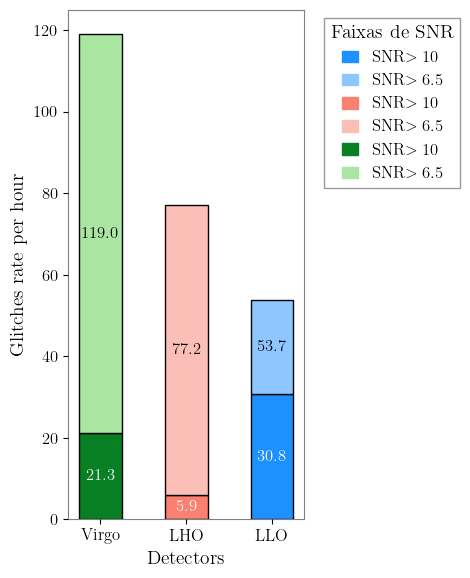

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Ajuste global de estilo e fonte tipo LaTeX
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'text.usetex': True,
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Dados
detectors = ['Virgo', 'LHO', 'LLO']

totals = [119.0, 77.2, 53.7]
cuts   = [21.3, 5.9, 30.8]

colors_dark = ['#087F23', '#fa8072', '#1e90ff']   # SNR > 10
colors_light = ['#A8E6A1', '#fcbfb8', '#8ec7ff']  # 6.5 < SNR < 10

fig, ax = plt.subplots(figsize=(5, 6))

bar_width = 0.5
x = np.arange(len(detectors))

for i, (total, cut, c_dark, c_light) in enumerate(zip(totals, cuts, colors_dark, colors_light)):
    # Parte escura (SNR > 10)
    ax.bar(x[i], cut, width=bar_width, color=c_dark, edgecolor='black')
    ax.text(x[i], cut/2, f'{cut:.1f}', ha='center', va='center', 
            color='white', fontsize=12, fontweight='bold')
    
    # Parte clara (6.5 < SNR < 10)
    remainder = total - cut
    ax.bar(x[i], remainder, bottom=cut, width=bar_width, color=c_light, edgecolor='black')
    ax.text(x[i], cut + remainder/2, f'{total:.1f}', ha='center', va='center',
            color='black', fontsize=12, fontweight='bold')

# Legenda
legend_patches = [
    Patch(color='#1e90ff', label=r'SNR$>10$'),
    Patch(color='#8ec7ff', label=r'SNR$>6.5$'),
    Patch(color='#fa8072', label=r'SNR$>10$'),
    Patch(color='#fcbfb8', label=r'SNR$>6.5$'),
    Patch(color='#087F23', label=r'SNR$>10$'),
    Patch(color='#A8E6A1', label=r'SNR$>6.5$')
]
ax.legend(handles=legend_patches, title='Faixas de SNR', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticks(x)
ax.set_xticklabels(detectors)
ax.set_xlabel('Detectors')
ax.set_ylabel('Glitches rate per hour')
'''axs[0].set_title("O4a")'''
plt.grid(None)
plt.tight_layout()
'''plt.savefig('glitches_rate_per_hour_4a.pdf')'''
plt.show()
